In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Fourth order well balanced MUSCL reconstruction

In [2]:
g = 9.81

def roe(hl, ul, hr, ur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    if hl<0 or hr<0:
        print 'negative h :(, hl,hr=%.3f,%.3f'%(hl,hr)

    if hl<1e-5 and hr <1e-5:
        return 0.0, 0.0
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)
    l1l = ul - np.sqrt(g*hl)
    l2l = ul + np.sqrt(g*hl)
    l1r = ur - np.sqrt(g*hr)
    l2r = ur + np.sqrt(g*hr)    
  
    #entropy fix programado en el surfwb-uc
    if l1>0:
        ws1 = wl1
        ws2 = wl2
    else:
        ws1 = wr1        
        if l2>0:
            ws2 = wl2
        else:
            ws2 = wr2

    us = 0.5*(ws1+ws2)
    hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if l1l<0 and l1r > 0:
        us = uhat
        hs = hhat
        
    if l2l<0 and l2r > 0:
        us = uhat
        hs = hhat
    #print hs,us
    return hs,us

In [3]:
def getSlopesReconstruction(h,nu,xic,xid):
    """
        Receives a 1D array h of size nx+6 and
        returns reconstructed values dhil,dhir,dhi+,dhi-,
        for indices i=-1...nx, given scalars nu, xic and xid.       
        The array has the following indexing
        
        
        -3 -2 -1  0  1  ...    nx   nx+1  nx+2  nx+3
        ---3---  --------nx-------   ------3--------        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
        
        
        Notice that hil,hir are unnecessary for i=-1
        and i=nx respectively, but stilled are returned 
        as output to make the code easier.
    """
    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = nx+3 +1 #i=nx (first ghost cell=(nx-1)+1), 
                   #+1 for python weird indexing on array operations
                   #doing h[j0:jf] gives "h_i" for i=-1...nx

    dhil = np.zeros((nx+2,))
    dhir = np.zeros((nx+2,))
    dhplus = np.zeros((nx+2,))
    dhminus = np.zeros((nx+2,))
    for i in range(2,nx+3+1):
        dhir[i-2] = (1.-nu)*(h[i+1]-h[i])+\
                    nu*(h[i]-h[i-1]) + \
                    xic*(-h[i-1] + 3.*h[i] -  3.*h[i+1] + h[i+2]) +\
                    xid*(-h[i-2] + 3.*h[i-1] -3.*h[i] +h[i+1])
        dhil[i-2] = (1.-nu)*(h[i] - h[i-1]) +\
                    nu*(h[i+1] - h[i]) + \
                    xic*(-h[i-2] +3.*h[i-1] -3.*h[i] +h[i+1]) + \
                    xid*(-h[i-1] + 3.*h[i] - 3.*h[i+1] + h[i+2])
        
        dhplus[i-2] = h[i+1] - h[i]
        
        dhminus[i-2] = h[i] - h[i-1]
        
    return dhil, dhir, dhplus, dhminus

In [4]:
def getSlopesReconstruction_2(h,nu,xic,xid):
    """
        Receives a 1D array h of size nx+6 and
        returns reconstructed values dhil,dhir,dhi+,dhi-,
        for indices i=-1...nx, given scalars nu, xic and xid.       
        The array has the following indexing
        
        ---3---  --------nx-------   ------3--------        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
        
        
        Notice that hil,hir are unnecessary for i=-1
        and i=nx respectively, but stilled are returned 
        as output to make the code easier.
    """
    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = nx+3 +1 #i=nx (first ghost cell=(nx-1)+1), 
                   #+1 for python weird indexing on array operations
                   #doing h[j0:jf] gives "h_i" for i=-1...nx
    

    dhil = (1.-nu)*(h[j0:jf]-h[j0-1:jf-1]) +\
        nu*(h[j0+1:jf+1]-h[j0:jf]) + \
        xic*(-h[j0-2:jf-2] +3.*h[j0-1:jf-1] -3.*h[j0:jf] + h[j0+1:jf+1])+\
        xid*(-h[j0-1:jf-1] +3.*h[j0:jf] - 3.*h[j0+1:jf+1] + h[j0+2:jf+2])
        
    dhir = (1.-nu)*(h[j0+1:jf+1])-h[j0:jf] +\
            nu*(h[j0:jf]-h[j0-1:jf-1]) +\
            xic*(-h[j0-1:jf-1] + 3.*h[j0:jf] - 3.*h[j0+1:jf+1] + h[j0+2:jf+2]) +\
            xid*(-h[j0-2:jf-2] + 3.*h[j0-1:jf-1] - 3.*h[j0:jf] + h[j0+1:jf+1])
        
    
    
    dhplus = h[j0+1:jf+1]-h[j0:jf]
    
    dhminus = h[j0:jf] - h[j0-1:jf-1]
    
    return dhil, dhir, dhplus, dhminus

In [5]:
def getSlopesReconstruction_3(h,nu,xic,xid):
    """
        Receives a 1D array h of size nx+6 and
        returns reconstructed values dhil,dhir,dhi+,dhi-,
        for indices i=-1...nx, given scalars nu, xic and xid.        
        
        Notice that hil,hir are unnecessary for i=-1
        and i=nx respectively, but stilled are returned 
        as output to make the code easier.
    """
    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = nx+3 +1 #i=nx (first ghost cell=(nx-1)+1), 
                   #+1 for python weird indexing on array operations
                   #doing h[j0:jf] gives "h_i" for i=-1...nx
    
    dhil = h[j0-2:jf-2]*(-xic) + \
        h[j0-1:jf-1]*(-1.0*(1.0-nu) + 3.0*xic - xid)+ \
        h[j0:jf]*(1.0-2.*nu - 3.*xic + 3.*xid) + \
        h[j0+1:jf+1]*(nu + xic -3.*xid) + \
        h[j0+2:jf+2]*(xid)
        
    dhir = h[j0-2:jf-2]*(-xid) + \
        h[j0-1:jf-1]*(-nu-xic+3*xid) +\
        h[j0:jf]*(-(1.-2.*nu) + 3.*xic - 3.*xid) + \
        h[j0+1:jf+1]*(1.-nu -3.*xic + xid) + \
        h[j0+2:jf+2]*(xic)   
    
    dhplus = h[j0+1:jf+1]-h[j0:jf]
    
    dhminus = h[j0:jf] - h[j0-1:jf-1]
    
    return dhil, dhir, dhplus, dhminus

In [6]:
def L(u,v,w):
    """
        u,v,w scalars
    """
    if u*v<=0:
        return 0.0
    else:
        return np.sign(u)*np.min([2.*np.abs(u),2.*np.abs(v),w])
Lvec = np.vectorize(L)    

In [7]:
def get4thMusclLimitedReconstruction(h):
    """
       Receives 1D array of size nx+6 and returns
       1d arrays hirL and hilL of size nx+1 with values
       of the 4th order MUSCL reconstruction for cells
       i= -1 ... nx
    """
    nu = 1.0/3.0
    xic = -1.0/10.0
    xid = -1.0/15.0

    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = (nx+3) +1 #i=nx, +1 for python weird indexing

    dhil, dhir, dhplus, dhminus = getSlopesReconstruction(h,nu,xic,xid)

    Lir = Lvec(dhminus, dhplus, dhir)
    Lil = Lvec(dhplus, dhminus, dhil)

    hirL = h[j0:jf] + 0.5*Lir
    hilL = h[j0:jf] - 0.5*Lil
    return hilL, hirL

# Hydrostatic reconstruction

In [8]:
def getHydrReconstr(dl,dr,hl,hr,ul,ur):
    """
        Receives values d_il, d_ir, h_il, h_ir, etc,
        in arrays dl,dr,hl,hr,ul,ur of size (nx+2) 
        (nx + 2 ghost cells)
        and calculates the hydrostatic reconstruction
        for h_{i+1/2^+} and h_{i+1/2-}.
        
        i goes from 2 to nx+3, for both input and output
        
        0, 1, 2, (3, 2, ..., nx+2), nx+3, nx+4, nx+5
    """
    nx = dl.shape[0]-2
    dinter = np.zeros((nx+1,))
    hp = np.zeros((nx+1,))
    up = np.zeros((nx+1,))
    hm = np.zeros((nx+1,))
    um = np.zeros((nx+1,))

    dinter = np.maximum(dr[:-1],dl[1:])
    hm = np.maximum(0., hr[:-1]+dr[:-1]-dinter)
    hp = np.maximum(0., hl[1:]+dl[1:]-dinter)
#     hum = np.where(hr[:-1]>0,hm*hur[:-1]/hr[:-1],0.)
#     hup = np.where(hl[1:]>0,hp*hul[1:]/hl[1:],0.)
    um = ur[:-1]
    up = ul[1:]
    return dinter, hm, hp, um, up

In [9]:
def sources(dl,dr,hl,hr,hp,hm):
    sp = np.zeros((2,hl[1:].shape[0]))
    sm = np.zeros((2,hm.shape[0]))
    sc = np.zeros((2,dl.shape[0]))
    sp[1,:] = 0.5*g*(hl[1:]**2-hp**2) #S_{i+1/2+}   
    sm[1,:] = 0.5*g*(-hm**2+hr[:-1]**2)    #S_{i+1/2-}
    sc[1,:] = 0.5*g*(hl+hr)*(dl-dr) #S_{c,i}
    return sp, sm, sc

In [10]:
def flux(h,u):
    """
        Receives scalars h,u
        Returns array F(u) of size 2
    """
    return np.array([h*u, 0.5*g*h**2 + h*u**2])

In [11]:
def fluxes_sources(d,hn,un,riemann_solver=roe,hmin=1e-10):
    """
        Receives 1D arrays h and u (1,nx+6)
        and returns array of fluxes (2,nx+1) for
        left and right interfaces of cells 
        0 to nx (total of nx+1)
    """
    nx = hn.shape[0]-6
    fs = np.zeros((2,nx+1))
    fp = np.zeros((2,nx+1))
    fm = np.zeros((2,nx+1))
    
    Lhl, Lhr = get4thMusclLimitedReconstruction(hn)
#     Lul, Lur = get4thMusclLimitedReconstruction(un)    
    Lhul, Lhur = get4thMusclLimitedReconstruction(un*hn)
    Lul = np.where(Lhl>1e-5, Lhul/Lhl, 0.0)
    Lur = np.where(Lhr>1e-5, Lhur/Lhr, 0.0)    

    Ldl, Ldr = get4thMusclLimitedReconstruction(d)

    dinter, hm, hp, um, up = getHydrReconstr(Ldl,Ldr,Lhl,Lhr,Lul,Lur)    
    sp, sm, sc = sources(Ldl,Ldr,Lhl,Lhr,hp,hm)
    

    fs = np.zeros((2,nx+1))
    for i in range(nx+1):
        hs,us = riemann_solver(hm[i],um[i],hp[i],up[i])
        fs[:,i] = flux(hs,us)
        
    fp = fs + sp
    fm = fs + sm
    return fp, fm, sc

In [12]:
def bcs_closed(h0,u0,*args):
    """ 
        receives matrices h,u (,nx+6) 
        to assign ghost cell values that simulate a 
        closed boundary: homogeneous Neumann on h
        and homogeneous Dirichlet on u.
        Returns new arrays h, u of size (,nx+6) 
        on which the boundary conditions have been applied
        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
    """
    nx = h.shape[0]-6
    j0 = 3
    jf = nx+2
    
    hb = np.copy(h0)
    ub = np.copy(u0)
    
    for k in range(1,4):
        
        #homogeneous neumann h
        hb[j0-k] = hb[j0+k-1]
        hb[jf+k] = hb[jf-k+1]
        
        #homogeneous dirichlet hu
        ub[j0-k] = -ub[j0+k-1]
        ub[jf+k] = -ub[jf+k-1]
    return hb,ub

In [13]:
def bcs_open(h0,u0,*args):
    """ 
        receives matrices h,u (,nx+6) 
        to assign ghost cell values that simulate a 
        closed boundary: homogeneous Neumann on h
        and homogeneous Neumann on u.
        Returns new arrays h, u of size (,nx+6) 
        on which the boundary conditions have been applied
        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
    """
    nx = h0.shape[0]-6
    j0 = 3
    jf = nx+2
    
    hb = np.copy(h0)
    ub = np.copy(u0)
    
    for k in range(1,4):
        
        #homogeneous neumann h
        hb[j0-k] = hb[j0+k-1]
        hb[jf+k] = hb[jf-k+1]
        
        #homogeneous dirichlet hu
        ub[j0-k] = ub[j0+k-1]
        ub[jf+k] = ub[jf+k-1]
    return hb,ub

In [14]:
def setdt(h0,u0,dx,cfl):
    """
        Calcula el dt segun condicion de CFL
    """
    s = np.max(np.abs(u0)+np.sqrt(9.81*h0))
    dt = cfl*dx/s
    return dt

In [15]:
def step(d, h0,u0,dx, bcs, riemann_solver, bcargs=[], hmin=1e-10):
    nx = h0.shape[0]-6
    h0 = np.where(h0<=hmin,hmin,h0)
    u0 = np.where(h0<=hmin,0.0,u0)    
    h0 = np.where(np.isnan(h0),0.0,h0)
    u0 = np.where(np.isnan(h0),0.0,u0)
    
    h0, u0 = bcs(h0,u0,*bcargs)
    
    fp, fm, sc = fluxes_sources(d,h0,u0,riemann_solver)
        
    F = np.zeros((2,nx+6))
    F[0,3:-3] = -1./dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]*1./dx
    F[1,3:-3] = -1./dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]*1./dx   
    
    return F

In [16]:
def solve_euler(d0,h0,u0,bcs,dx,cfl,t0,nt,tol,riemann_solver,bcargs=[]):
    """
        Main routine that runs the simulation.
        INPUT:
        h,hu: numpy arrays (nt,nx+6) to store the solution.
             Must have the initial condition defined on the 
             first row.
        dx: cell size
        cfl: CFL number for time step
        t0: starting time of the simulation
        nt: number of time steps desired for the simulation
        tol: tolerance for dry bottom
    """
    nx = h0.shape[0]
    d = np.zeros(nx+6)
    h = np.zeros((nt,nx+6))
    u = np.zeros((nt,nx+6))
    h[0,3:-3] = h0
    u[0,3:-3] = u0
    
    t = np.zeros((nt,))
    t[0] = t0
    

    for n in range(nt-1):
        dt = setdt(h[n,:],u[n,:],dx,cfl)
        t[n+1] = t[n] + dt

        F = step(d, h[n,:],u[n,:], dx, bcs, riemann_solver,
                 bcargs=bcargs,hmin=tol)
        
        h[n+1,:] = h[n,:] + F[0,:]*dt
        hu = h[n,:]*u[n,:] + F[1,:]*dt        
        u[n+1,:] = np.where(h[n+1,:]>tol, hu/h[n+1,:], 0.0)
        
    return t,h[:,3:-3],u[:,3:-3]

In [17]:
def solve_rk4(d0,h0,u0,bcs,dx,cfl,t0,nt,tol,riemann_solver,bcargs=[]):
    """
        Main routine that runs the simulation.
        INPUT:
        h,hu: numpy arrays (nt,nx+6) to store the solution.
             Must have the initial condition defined on the 
             first row.
        dx: cell size
        cfl: CFL number for time step
        t0: starting time of the simulation
        nt: number of time steps desired for the simulation
        tol: tolerance for dry bottom
    """
    nx = h0.shape[0]
    d = np.zeros(nx+6)
    h = np.zeros((nt,nx+6))
    u = np.zeros((nt,nx+6))
    h[0,3:-3] = h0
    u[0,3:-3] = u0
    
    t = np.zeros((nt,))
    t[0] = t0
    

    for n in range(nt-1):
        dt = setdt(h[n,:],u[n,:],dx,cfl)
        t[n+1] = t[n] + dt
        
        h1 = h[n,:]
        u1 = u[n,:]
        k1 = step(d, h1, u1, dx, bcs, riemann_solver,
                 bcargs=bcargs,hmin=tol)
        
        h2 = h[n,:] + 0.5*dt*k1[0,:]
        u2 = np.where( h2>tol, (h[n,:]*u[n,:]+0.5*k1[1,:]*dt)/h2, 0.0)
        k2 = step(d, h2, u2, dx, bcs, riemann_solver,
                 bcargs=bcargs,hmin=tol)
        
        h3 = h[n,:] + 0.5*dt*k2[0,:]
        u3 = np.where( h3>tol, (h[n,:]*u[n,:]+0.5*k2[1,:]*dt)/h3, 0.0)
        k3 = step(d, h3, u3, dx, bcs, riemann_solver,
                 bcargs=bcargs,hmin=tol)        
        
        h4 = h[n,:] + k3[0,:]*dt
        u4 = np.where(h4>tol, (h[n,:]*u[n,:]+k3[1,:]*dt)/h4, 0.0)
        k4 = step(d, h4, u4, dx, bcs, riemann_solver,
                 bcargs=bcargs,hmin=tol)
        
        h[n+1,:] = h[n,:] + dt/6.*(k1[0,:]+2.*k2[0,:]+2.*k3[0,:]+k4[0,:])
        hu = h[n,:]*u[n,:] + dt/6.*(k1[1,:]+2.*k2[1,:]+2.*k3[1,:]+k4[1,:])
        u[n+1,:] = np.where(h[n+1,:]>tol, hu/h[n+1,:], 0.0)
        
    return t,h[:,3:-3],u[:,3:-3]

Una iteración

### Boundary conditions

# Lake at rest

From Berthon and Marche (2008), section 6.3.

The topography is defined by

$$ d(x,y)  = \begin{cases}
0.2 - 0.05(x-10)^2 & \text{ if } 8m < x < 12m \\
0 & \text{ else}
\end{cases}$$

and the water level is set to $0.1m$

In [18]:
nt = 200
nx = 100
cfl = 0.1
t0 = 0.0

In [46]:
x = np.linspace(0,25,nx)
dx = np.diff(x)[0]
d0 = np.where((x>8)*(x<12), 0.2-0.05*(x-10.)**2, 0.0)*0.1
# d0 = np.where((x>8)*(x<12),0.02,0.0)*4
h0 = np.where(0.1-d0>=0, 0.1-d0, 0.0)
# h0 = np.where(np.abs(x-10.0)<=5,np.exp(-(x-10)**2/2**2)*0.1+0.1,0.1)
# h0 = np.cos((x-10)*2*np.pi/10.)*0.5+1.0
u0 = np.zeros_like(h0)

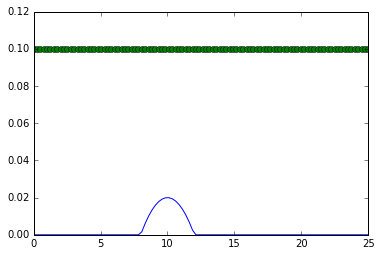

In [47]:
plt.plot(x,d0)
plt.plot(x,h0+d0,'o')

In [56]:
t,h,u = solve_rk4(d0,h0+d0,u0,bcs_open,dx,cfl,t0,nt,1e-5,roe)

/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in divide
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in divide
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in divide
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in divide


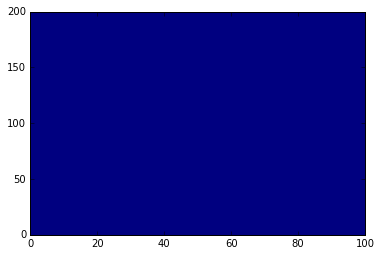

In [57]:
plt.pcolormesh(h)


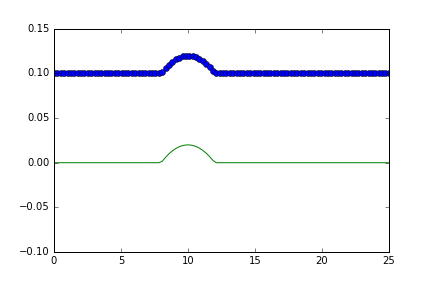
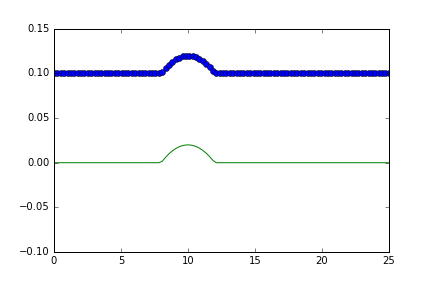
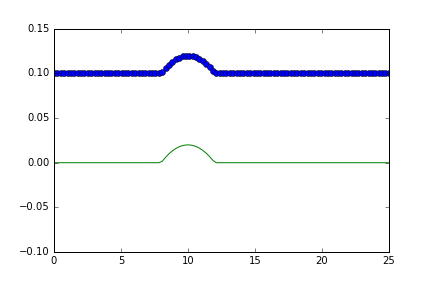
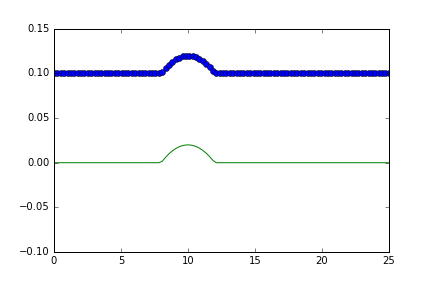
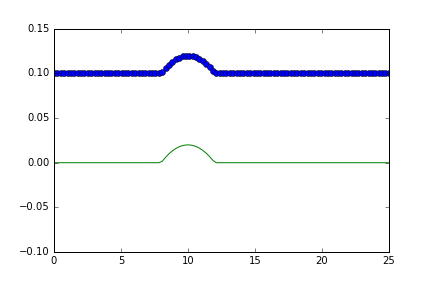
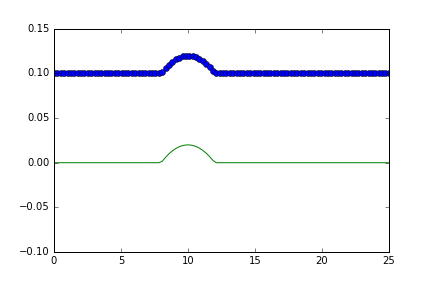
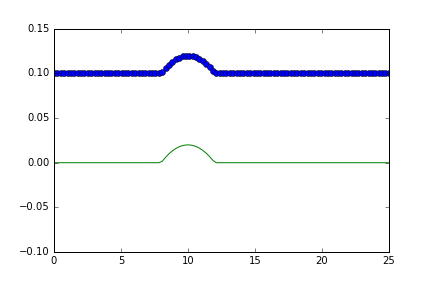
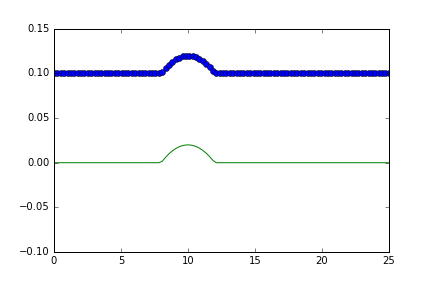
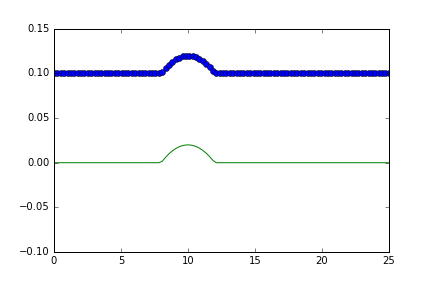
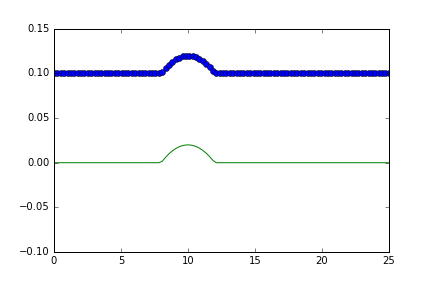
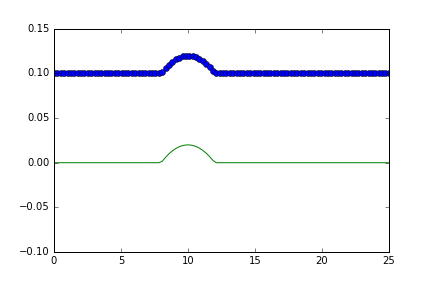
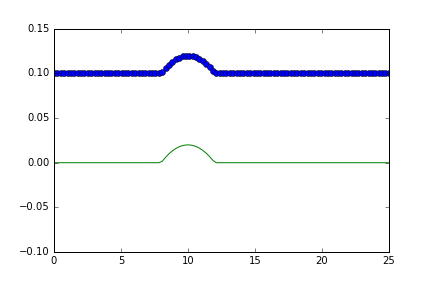
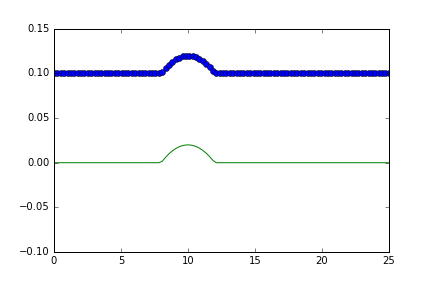
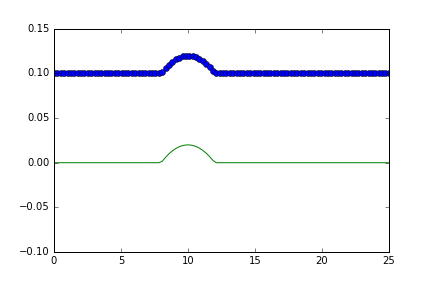
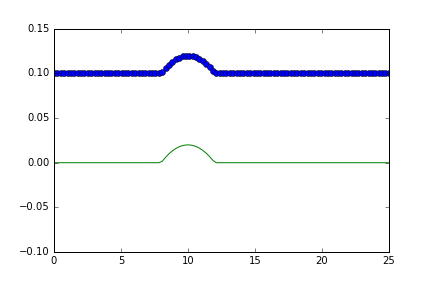
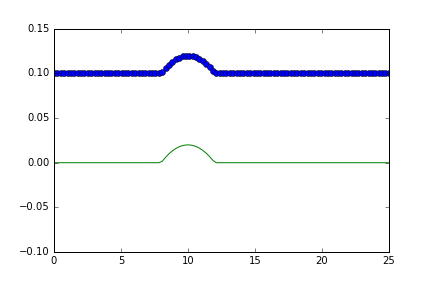
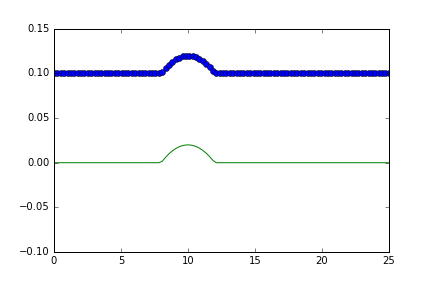
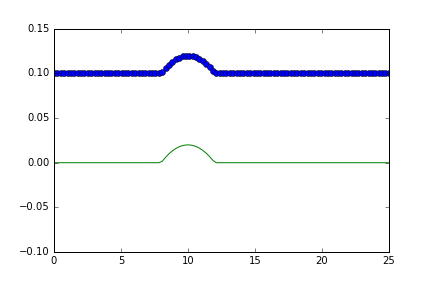
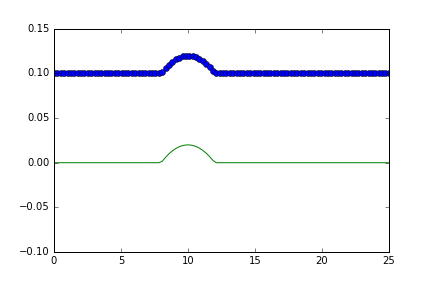
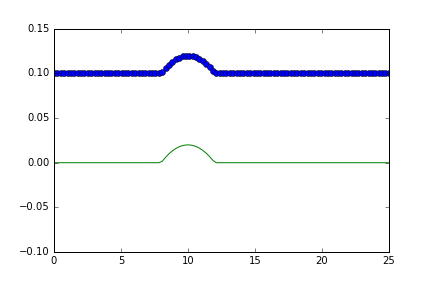

In [58]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 25), ylim=(-0.1,0.15))
line, = ax.plot([], [], 'o',lw=2)
lineb, = ax.plot(x,d0)

def animate(i):
    i = min(i*10,nt-1)
    line.set_data(x, d0+h[i,:])
    return line,

animation.FuncAnimation(fig, animate, frames=nt/10, interval=45)